# Think Bayes

This notebook presents example code and exercise solutions for Think Bayes.

Copyright 2018 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT

In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import classes from thinkbayes2
from thinkbayes2 import Pmf, Suite

import thinkbayes2
import thinkplot

import numpy as np
from scipy.special import gamma

## The World Cup Problem, Part One

>In the 2014 FIFA World Cup, Germany played Brazil in a semifinal match. Germany scored after 11 minutes and again at the 23 minute mark. At that point in the match, how many goals would you expect Germany to score after 90 minutes? What was the probability that they would score 5 more goals (as, in fact, they did)?

Let's assume that Germany has some hypothetical goal-scoring rate, λ, in goals per game.

To represent the prior distribution of λ, I'll use a Gamma distribution with mean 1.3, which is the average number of goals per team per game in World Cup play.

Here's what the prior looks like.

1.310359949002256

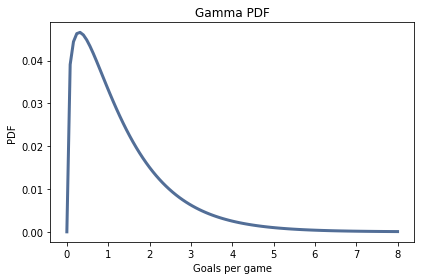

In [2]:
from thinkbayes2 import MakeGammaPmf

xs = np.linspace(0, 8, 101)
pmf = MakeGammaPmf(xs, 1.3)
thinkplot.Pdf(pmf)
thinkplot.decorate(title='Gamma PDF',
                   xlabel='Goals per game',
                   ylabel='PDF')
pmf.Mean()

**Exercise:**  Write a class called `Soccer` that extends `Suite` and defines `Likelihood`, which should compute the probability of the data (the time between goals in minutes) for a hypothetical goal-scoring rate, `lam`, in goals per game.

Hint: For a given value of `lam`, the time between goals is distributed exponentially.

Here's an outline to get you started:

In [3]:
class Soccer(Suite):
    """Represents hypotheses about goal-scoring rates."""

    def Likelihood(self, data, hypo):
        """Computes the likelihood of the data under the hypothesis.

        hypo: scoring rate in goals per game
        data: interarrival time in minutes
        """
        return 1

In [4]:
# Solution goes here

Now we can create a `Soccer` object and initialize it with the prior Pmf:

1.3103599490022553

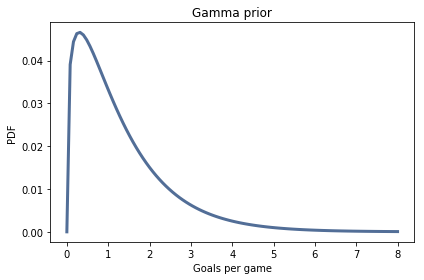

In [5]:
soccer = Soccer(pmf)
thinkplot.Pdf(soccer)
thinkplot.decorate(title='Gamma prior',
                   xlabel='Goals per game',
                   ylabel='PDF')
soccer.Mean()

Here's the update after first goal at 11 minutes.

1.310359949002255

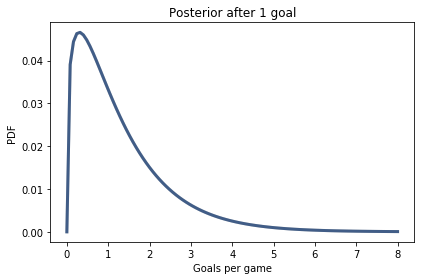

In [6]:
thinkplot.Pdf(soccer, color='0.7')
soccer.Update(11)
thinkplot.Pdf(soccer)
thinkplot.decorate(title='Posterior after 1 goal',
                   xlabel='Goals per game',
                   ylabel='PDF')
soccer.Mean()

Here's the update after the second goal at 23 minutes (the time between first and second goals is 12 minutes).


1.3103599490022553

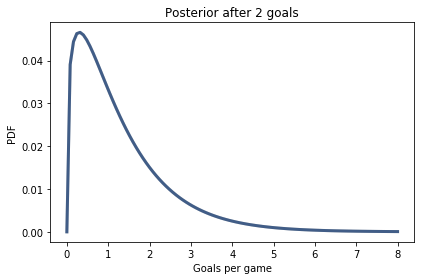

In [7]:
thinkplot.Pdf(soccer, color='0.7')
soccer.Update(12)
thinkplot.Pdf(soccer)
thinkplot.decorate(title='Posterior after 2 goals',
                   xlabel='Goals per game',
                   ylabel='PDF')
soccer.Mean()

This distribution represents our belief about `lam` after two goals.

## Estimating the predictive distribution

Now to predict the number of goals in the remaining 67 minutes.  There are two sources of uncertainty:

1. We don't know the true value of λ.

2. Even if we did we wouldn't know how many goals would be scored.

We can quantify both sources of uncertainty at the same time, like this:

1. Choose a random value from the posterior distribution of λ.

2. Use the chosen value to generate a random number of goals.

If we run these steps many times, we can estimate the distribution of goals scored.

We can sample a value from the posterior like this:

In [8]:
lam = soccer.Random()
lam

2.48

Given `lam`, the number of goals scored in the remaining 67 minutes comes from the Poisson distribution with parameter `lam * t`, with `t` in units of goals.

So we can generate a random value like this:

In [9]:
t = 67 / 90
np.random.poisson(lam * t)

3

If we generate a large sample, we can see the shape of the distribution:

1.8335

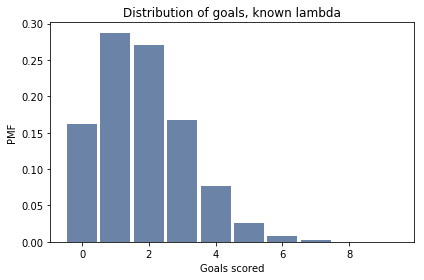

In [10]:
sample = np.random.poisson(lam * t, size=10000)
pmf = Pmf(sample)
thinkplot.Hist(pmf)
thinkplot.decorate(title='Distribution of goals, known lambda',
                   xlabel='Goals scored', 
                   ylabel='PMF')
pmf.Mean()

But that's based on a single value of `lam`, so it doesn't take into account both sources of uncertainty.  Instead, we should sample values from the posterior distribution and generate one prediction for each.

**Exercise:** Write a few lines of code to

1. Use `Pmf.Sample` to generate a sample with `n=10000` from the posterior distribution `soccer`.

2. Use `np.random.poisson` to generate a random number of goals from the Poisson distribution with parameter $\lambda t$, where `t` is the remaining time in the game (in units of games).

3. Plot the distribution of the predicted number of goals, and print its mean.

4. What is the probability of scoring 5 or more goals in the remainder of the game?

In [11]:
# Solution goes here

In [12]:
# Solution goes here

## Computing the predictive distribution

Alternatively, we can compute the predictive distribution by making a mixture of Poisson distributions.

`MakePoissonPmf` makes a Pmf that represents a Poisson distribution.

In [13]:
from thinkbayes2 import MakePoissonPmf

If we assume that `lam` is the mean of the posterior, we can generate a predictive distribution for the number of goals in the remainder of the game.

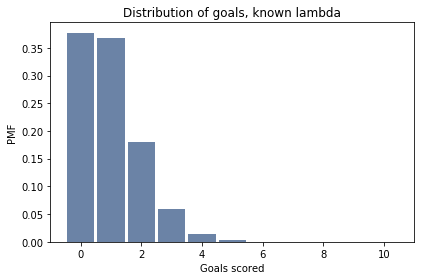

In [14]:
lam = soccer.Mean()
rem_time = 90 - 23
lt = lam * rem_time / 90
pred = MakePoissonPmf(lt, 10)
thinkplot.Hist(pred)
thinkplot.decorate(title='Distribution of goals, known lambda',
                   xlabel='Goals scored', 
                   ylabel='PMF')

The predictive mean is about 2 goals.

In [15]:
pred.Mean()

0.9754901051822877

And the chance of scoring 5 more goals is still small.

In [16]:
pred.ProbGreater(4)

0.003297768976804021

But that answer is only approximate because it does not take into account our uncertainty about `lam`.

The correct method is to compute a weighted mixture of Poisson distributions, one for each possible value of `lam`.

The following figure shows the different predictive distributions for the different values of `lam`.

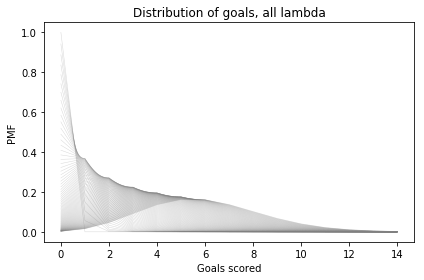

In [17]:
for lam, prob in soccer.Items():
    lt = lam * rem_time / 90
    pred = MakePoissonPmf(lt, 14)
    thinkplot.Pdf(pred, color='gray', alpha=0.3, linewidth=0.5)

thinkplot.decorate(title='Distribution of goals, all lambda',
                   xlabel='Goals scored', 
                   ylabel='PMF')

We can compute the mixture of these distributions by making a Meta-Pmf that maps from each Poisson Pmf to its probability.

In [18]:
metapmf = Pmf()

for lam, prob in soccer.Items():
    lt = lam * rem_time / 90
    pred = MakePoissonPmf(lt, 15)
    metapmf[pred] = prob

`MakeMixture` takes a Meta-Pmf (a Pmf that contains Pmfs) and returns a single Pmf that represents the weighted mixture of distributions:

In [19]:
def MakeMixture(metapmf, label='mix'):
    """Make a mixture distribution.

    Args:
      metapmf: Pmf that maps from Pmfs to probs.
      label: string label for the new Pmf.

    Returns: Pmf object.
    """
    mix = Pmf(label=label)
    for pmf, p1 in metapmf.Items():
        for x, p2 in pmf.Items():
            mix[x] += p1 * p2
    return mix

Here's the result for the World Cup problem.

In [20]:
mix = MakeMixture(metapmf)
mix.Print()

0 0.47924077724207537
1 0.2725094835016371
2 0.133775655946909
3 0.06276271009361287
4 0.028740536131222984
5 0.01293828440488025
6 0.005734953182524395
7 0.002498793148679157
8 0.001066322124209203
9 0.00044359776122528073
10 0.00017904726009230283
11 6.981959531261281e-05
12 2.62143057581813e-05
13 9.453212961538524e-06
14 3.268979546003684e-06
15 1.0831093530869543e-06


And here's what the mixture looks like.

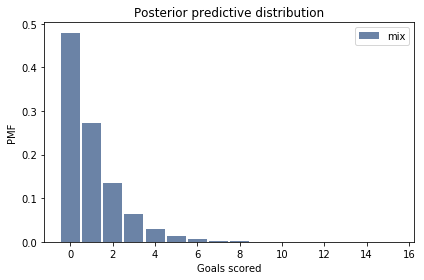

In [21]:
thinkplot.Hist(mix)
thinkplot.decorate(title='Posterior predictive distribution',
                   xlabel='Goals scored', 
                   ylabel='PMF')

**Exercise:** Compute the predictive mean and the probability of scoring 5 or more additional goals.

In [22]:
# Solution goes here